In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
from utility_funcs import get_train_labels_test, split_train_data, scale_and_as_array


In [2]:
train, labels, test = get_train_labels_test()


In [3]:
features = [f for f in train.columns if "sensor" in f]


In [4]:
groups = train["sequence"]
train = train.drop(["sequence", "subject", "step"], axis=1).values
test = test.drop(["sequence", "subject", "step"], axis=1).values
labels = labels["state"]

scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)


train = train.reshape(-1, 60, 13)
test = test.reshape(-1, 60, 13)

assert train.shape[0] == labels.shape[0]

### Helper functions 

In [5]:
def train_model(model_in, test_pred_mode = False):

    gkf = GroupKFold(3)
    store = []

    model_in.summary()

    for fold, (train_idx, val_idx) in enumerate(
        gkf.split(train, labels, groups.unique())
    ):
        print(f"Fitting fold {fold} for {model_in.name}...")
        model = keras.models.clone_model(model_in)
        model.compile(
            optimizer="adam", loss="binary_crossentropy", metrics=[keras.metrics.AUC()]
        )

        X_train, X_val = train[train_idx], train[val_idx]
        y_train, y_val = labels.iloc[train_idx], labels.iloc[val_idx]

        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            epochs=100,
            verbose=1,
            batch_size=256,
            callbacks=[
                keras.callbacks.EarlyStopping(
                    patience=5, monitor="val_loss", restore_best_weights=True
                )
            ],
        )
        auc = roc_auc_score(y_val, model.predict(X_val).squeeze())
        print(f"The val auc for fold {fold}, {model_in.name} is {auc}")

        plot_model(history, model, fold)

        if test_pred_mode:
            store.append(model.predict(test).squeeze())
        else:
            store.append(auc)
            
    result = sum(store) / 3 # if test mode we want the prediction
    return result


def plot_model(history, model, fold):

    l_name = list(history.history.keys())[0]
    vl_name = list(history.history.keys())[2]
    a_name = list(history.history.keys())[1]
    al_name = list(history.history.keys())[3]

    loss, val_loss = history.history[l_name], history.history[vl_name]
    auc, val_auc = history.history[a_name], history.history[al_name]
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(15, 8))
    plt.plot(
        epochs,
        loss,
        color="tab:blue",
        linestyle="-",
        linewidth=2,
        marker="*",
        label="Training loss",
    )
    plt.plot(
        epochs,
        val_loss,
        color="tab:orange",
        linestyle="-",
        marker="o",
        label="Validation loss",
    )
    plt.title(f"Training and validation loss, {model.name}, fold {fold}", fontsize=16)
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.legend(loc="upper right", fontsize="x-large")
    plt.tick_params(labelsize=14)
    plt.show()
    plt.clf()

    plt.figure(figsize=(15, 8))
    plt.plot(
        epochs,
        auc,
        color="tab:blue",
        linestyle="-",
        linewidth=2,
        marker="*",
        label="Training auc",
    )
    plt.plot(
        epochs,
        val_auc,
        color="tab:orange",
        linestyle="-",
        marker="o",
        label="Validation auc",
    )
    plt.title(f"Training and validation auc, {model.name}, fold {fold}", fontsize=16)
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Auc", fontsize=16)
    plt.legend(loc="upper left", fontsize="x-large")
    plt.tick_params(labelsize=14)
    plt.show()
    plt.clf()


### test models

In [6]:
model_1 = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=(60, train.shape[2])),
        keras.layers.Dense(50, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ],
    name="Dense_model_1",
)


model_2 = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=(60, train.shape[2])),
        keras.layers.Dense(200, activation="relu"),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(50, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ],
    name="Dense_model_2",
)

model_3 = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=(60, train.shape[2])),
        keras.layers.Dense(400, activation="swish"),
        keras.layers.Dense(200, activation="swish"),
        keras.layers.Dense(100, activation="swish"),
        keras.layers.Dense(50, activation="swish"),
        keras.layers.Dense(1, activation="sigmoid"),
    ],
    name="Dense_model_3",
)

model_4 = keras.models.Sequential(
    [
        keras.layers.Input(shape=(60, train.shape[2])),
        keras.layers.Conv1D(32, 7),
        keras.layers.MaxPooling1D(),
        keras.layers.Conv1D(64, 3),
        keras.layers.MaxPooling1D(),
        keras.layers.Conv1D(128, 3),
        keras.layers.GlobalMaxPooling1D(),
        keras.layers.Dense(150, activation="swish"),
        keras.layers.Dense(50, activation="swish"),
        keras.layers.Dense(1, activation="sigmoid"),
    ], 
    name="CNN_model_1",
)


model_5 = keras.models.Sequential([
    keras.layers.Input(shape=(60, train.shape[2])),
    keras.layers.LSTM(128, return_sequences=True), 
    keras.layers.Flatten(),
    keras.layers.Dense(50, activation="swish"),
    keras.layers.Dense(1, activation="sigmoid")
], name = 'RNN_model_1')



model_6 = keras.models.Sequential([
    keras.layers.Input(shape=(60, train.shape[2])),
    keras.layers.LSTM(256, return_sequences=True), 
    keras.layers.LSTM(128, return_sequences=True), 
    keras.layers.Flatten(),
    keras.layers.Dense(150, activation="swish"),
    keras.layers.Dense(50, activation="swish"),
    keras.layers.Dense(1, activation="sigmoid")
], name = 'RNN_model_2')

model_7 = keras.models.Sequential([
    keras.layers.Input(shape=(60, train.shape[2])),
    keras.layers.LSTM(512, return_sequences=True), 
    keras.layers.LSTM(256, return_sequences=True), 
    keras.layers.LSTM(128, return_sequences=True), 
    keras.layers.Flatten(),
    keras.layers.Dense(150, activation="swish"),
    keras.layers.Dense(50, activation="swish"),
    keras.layers.Dense(1, activation="sigmoid")
], name = 'RNN_model_3')


model_8 = keras.models.Sequential([
    keras.layers.Input(shape=(60, train.shape[2])),
    keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)), 
    keras.layers.Flatten(),
    keras.layers.Dense(50, activation="swish"),
    keras.layers.Dense(1, activation="sigmoid")
], name = 'RNN_model_4')

model_9 = keras.models.Sequential([
    keras.layers.Input(shape=(60, train.shape[2])),
    keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True)), 
    keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)), 
    keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)), 
    keras.layers.Flatten(),
    keras.layers.Dense(150, activation="swish"),
    keras.layers.Dense(50, activation="swish"),
    keras.layers.Dense(1, activation="sigmoid")
], name = 'RNN_model_5')

model_10 = keras.models.Sequential([
    keras.layers.Input(shape=(60, train.shape[2])),
    keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True)), 
    keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)), 
    keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)), 
    keras.layers.Conv1D(32, 7),
    keras.layers.MaxPooling1D(),
    keras.layers.Conv1D(64, 3),
    keras.layers.MaxPooling1D(),
    keras.layers.Conv1D(128, 3),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(150, activation="swish"),
    keras.layers.Dense(50, activation="swish"),
    keras.layers.Dense(1, activation="sigmoid"),
], name = 'CNN_RNN_model_1')

Model: "RNN_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           72704     
                                                                 
 flatten_3 (Flatten)         (None, 7680)              0         
                                                                 
 dense_14 (Dense)            (None, 50)                384050    
                                                                 
 dense_15 (Dense)            (None, 1)                 51        
                                                                 
Total params: 456,805
Trainable params: 456,805
Non-trainable params: 0
_________________________________________________________________
Fitting fold 0 for RNN_model_1...
Epoch 1/100
68/68 [==============================] - 14s 20ms/step - loss: 0.6818 - auc: 0.5877 - val_loss: 0.6690 - val_auc: 0.6216
Epoch 2/100
68

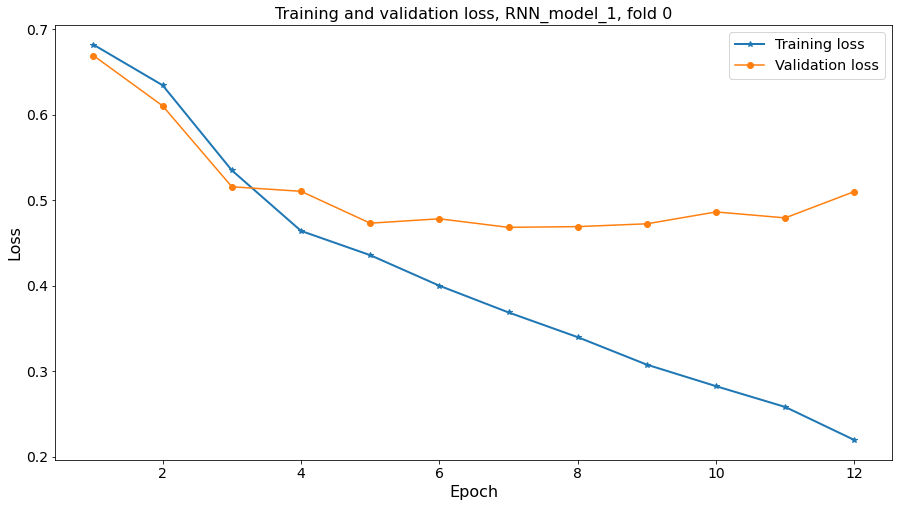

<Figure size 432x288 with 0 Axes>

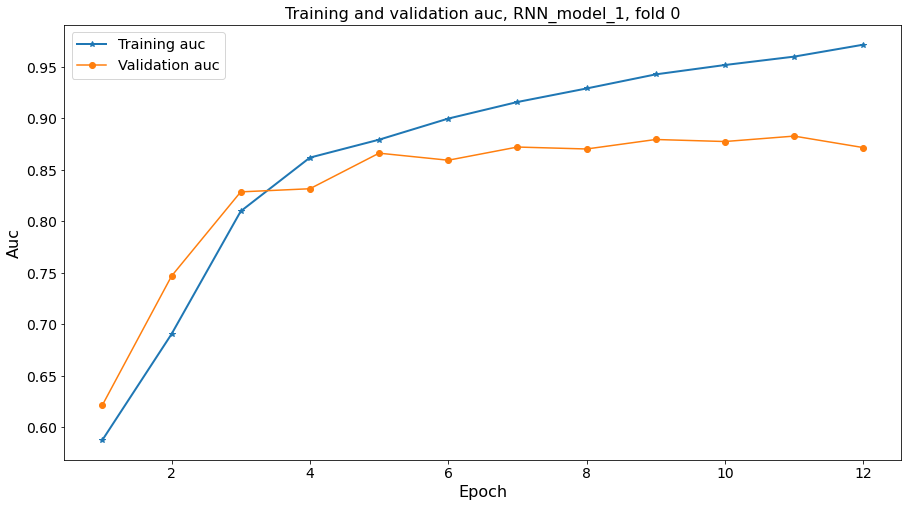

Fitting fold 1 for RNN_model_1...
Epoch 1/100
68/68 [==============================] - 2s 20ms/step - loss: 0.6803 - auc_1: 0.5910 - val_loss: 0.6644 - val_auc_1: 0.6397
Epoch 2/100
68/68 [==============================] - 1s 14ms/step - loss: 0.6258 - auc_1: 0.7052 - val_loss: 0.5918 - val_auc_1: 0.7630
Epoch 3/100
68/68 [==============================] - 1s 14ms/step - loss: 0.5472 - auc_1: 0.7992 - val_loss: 0.5051 - val_auc_1: 0.8359
Epoch 4/100
68/68 [==============================] - 1s 14ms/step - loss: 0.4698 - auc_1: 0.8591 - val_loss: 0.4782 - val_auc_1: 0.8556
Epoch 5/100
68/68 [==============================] - 1s 14ms/step - loss: 0.4295 - auc_1: 0.8838 - val_loss: 0.4642 - val_auc_1: 0.8671
Epoch 6/100
68/68 [==============================] - 1s 14ms/step - loss: 0.3976 - auc_1: 0.9011 - val_loss: 0.4446 - val_auc_1: 0.8799
Epoch 7/100
68/68 [==============================] - 1s 14ms/step - loss: 0.3593 - auc_1: 0.9200 - val_loss: 0.4586 - val_auc_1: 0.8729
Epoch 8/100
68

<Figure size 432x288 with 0 Axes>

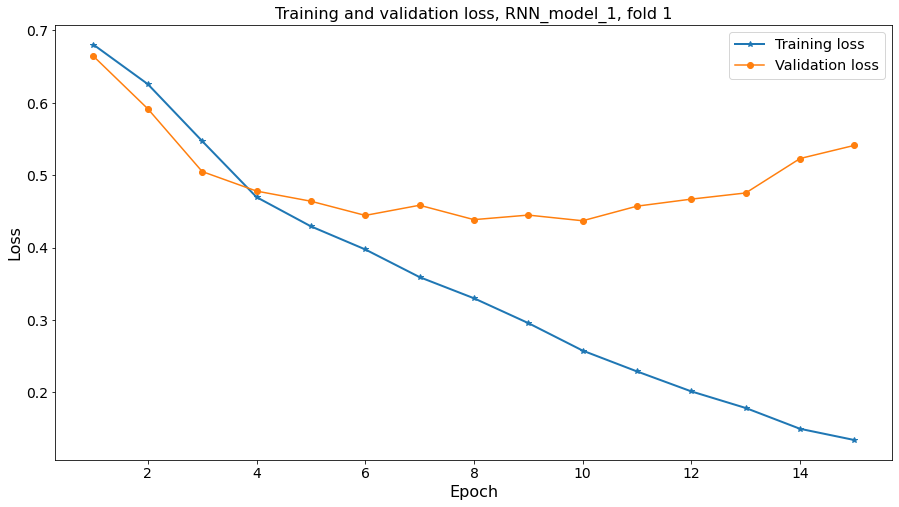

<Figure size 432x288 with 0 Axes>

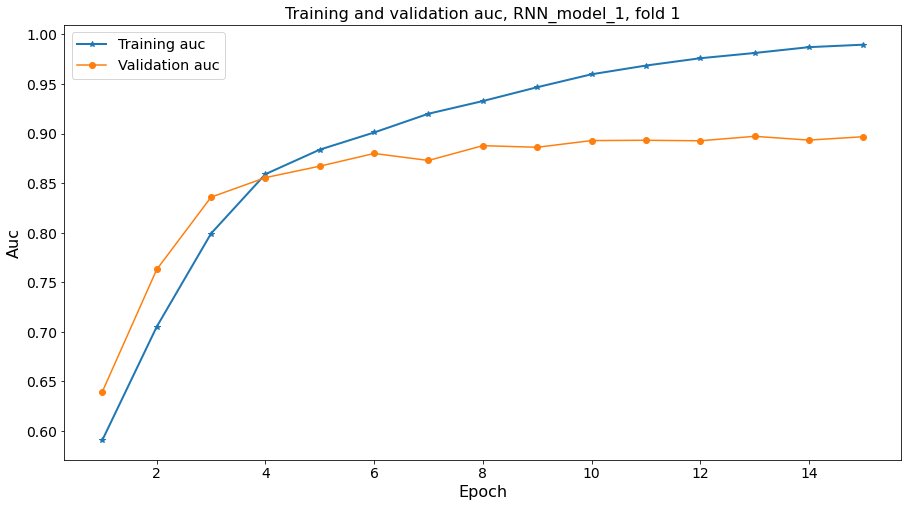

Fitting fold 2 for RNN_model_1...
Epoch 1/100
68/68 [==============================] - 3s 18ms/step - loss: 0.6851 - auc_2: 0.5818 - val_loss: 0.6743 - val_auc_2: 0.6072
Epoch 2/100
68/68 [==============================] - 1s 13ms/step - loss: 0.6367 - auc_2: 0.6864 - val_loss: 0.6136 - val_auc_2: 0.7209
Epoch 3/100
68/68 [==============================] - 1s 12ms/step - loss: 0.5352 - auc_2: 0.8097 - val_loss: 0.5209 - val_auc_2: 0.8258
Epoch 4/100
68/68 [==============================] - 1s 14ms/step - loss: 0.4652 - auc_2: 0.8628 - val_loss: 0.5006 - val_auc_2: 0.8440
Epoch 5/100
68/68 [==============================] - 1s 14ms/step - loss: 0.4227 - auc_2: 0.8879 - val_loss: 0.4709 - val_auc_2: 0.8620
Epoch 6/100
68/68 [==============================] - 1s 15ms/step - loss: 0.3952 - auc_2: 0.9028 - val_loss: 0.4902 - val_auc_2: 0.8506
Epoch 7/100
68/68 [==============================] - 1s 15ms/step - loss: 0.3686 - auc_2: 0.9164 - val_loss: 0.4828 - val_auc_2: 0.8659
Epoch 8/100
68

<Figure size 432x288 with 0 Axes>

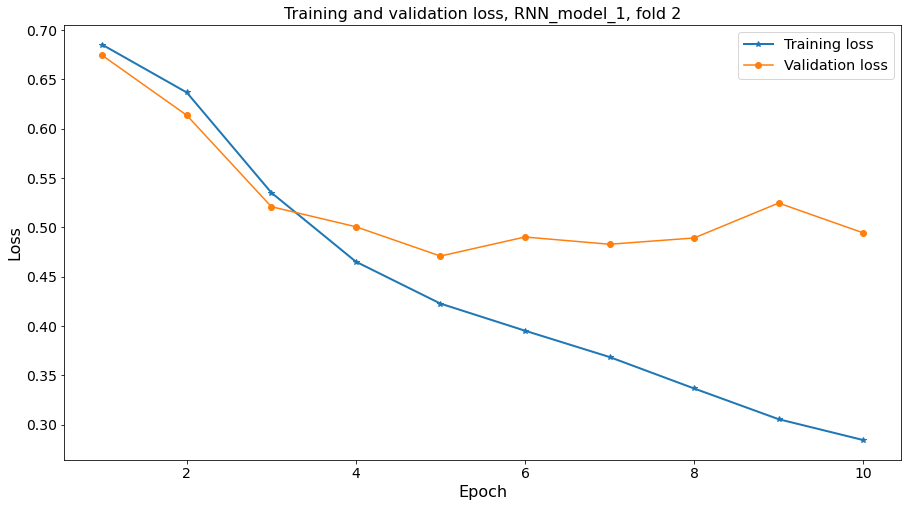

<Figure size 432x288 with 0 Axes>

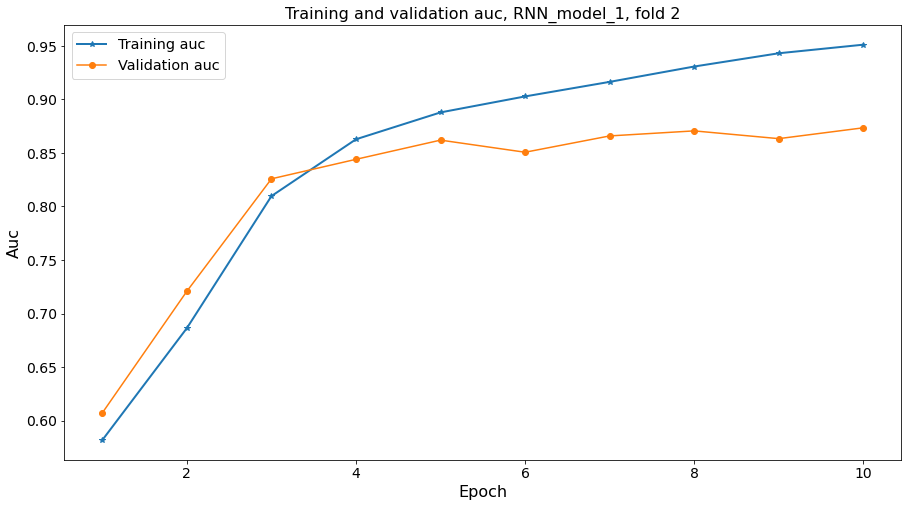

Model: "RNN_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 60, 256)           276480    
                                                                 
 lstm_2 (LSTM)               (None, 60, 128)           197120    
                                                                 
 flatten_4 (Flatten)         (None, 7680)              0         
                                                                 
 dense_16 (Dense)            (None, 150)               1152150   
                                                                 
 dense_17 (Dense)            (None, 50)                7550      
                                                                 
 dense_18 (Dense)            (None, 1)                 51        
                                                                 
Total params: 1,633,351
Trainable params: 1,633,351
Non

In [7]:
models = [model_5, model_6, model_7, model_8, model_9, model_10] ## skip 1-4 as poor performance 
model_dict = {}
for i, model_in in enumerate(models):
    val_auc = train_model(model_in)
    model_dict[model_in.name] = val_auc
